In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Colab\ Notebooks/data/new-york-city-taxi-fare-prediction.zip > /dev/null

In [ ]:
! pip install joblibspark

In [ ]:
! pip install pyspark

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 45.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0aab63993d9cc0c320b28ff87b85c39b9e65e8c2c884b7a30d4c08d5df854e04
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("Final_Project") \
    .getOrCreate()

In [ ]:
df = pd.read_csv('train.csv', nrows=4_000_000)

The task is to predicting the fare amount for a taxi ride in New York City given pickup and dropoff locations, date, time, and number of passenders)
(https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview) (there are 55 million records in train file)

In [ ]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

# Data Cleaning

In [ ]:
df.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    29
dropoff_latitude     29
passenger_count       0
dtype: int64

As the number of missing values is quite low. They were dropped

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(3999971, 8)

# Removing invalid data 
The borders for longitude and latitude: -74.9 and -72.9, 40.47 and 41.04. The number of passengers cannot be more than 7

In [ ]:
df = df[df['fare_amount'] > 0]
df = df[df['passenger_count'] > 0]
df = df[df['passenger_count'] < 7]
df = df[df['pickup_longitude'] < -72.9]
df = df[df['pickup_longitude'] > -74.5]
df = df[df['dropoff_longitude'] < -72.9]
df = df[df['dropoff_longitude'] > -74.5]
df = df[df['pickup_latitude'] < 41.04]
df = df[df['pickup_latitude'] > 40.47]
df = df[df['dropoff_latitude'] < 41.04]
df = df[df['dropoff_latitude'] > 40.47]
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Data Transformstion

From key feature 4 new columns were created (year, month, day, hour)

In [ ]:
df['key_1'] = df['pickup_datetime'].apply(lambda x: x.split())
df['key_2']= df['key_1'].apply(lambda x: x[0].split('-'))
df['key_3'] = df['key_1'].apply(lambda x: x[0])
df['date'] = pd.to_datetime(df['key_3'])
df['day'] = df['date'].dt.day_name()
df['year'] = df['key_2'].apply(lambda x: int(x[0]))
df['month'] = df['key_2'].apply(lambda x: int(x[1]))

df['key_2']=df['key_1'].apply(lambda x: x[1].split(':'))
df['hour'] = df['key_2'].apply(lambda x: int(x[0]))
df = df.drop(['key', 'pickup_datetime', 'key_1', 'key_2', 'key_3', 'date'], axis=1)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,Monday,2009,6,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,Tuesday,2010,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,Thursday,2011,8,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,Saturday,2012,4,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,Tuesday,2010,3,7


Converting categorical feature 'day' to numerical using OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc_t = enc.fit_transform(df[['day']])
df[enc.categories_[0]] = enc_t.toarray()
df = df.drop(['day'], axis=1)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,17,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0


As the distances are small. We can calculate them using Pythagorian's theorem on eqirectangular projection: 
### x = cos((lat1 + lat2)* PI / 360) * (lon1 - lon2) * PI /180
### y = (lat1 - lat2) * PI / 180
### d = R * sqrt(x^2 +y^2)

In [ ]:
R = 6371
df['longitude_distance'] = (df['pickup_longitude'] - df['dropoff_longitude'])
df['latitude_distance'] = (df['pickup_latitude'] - df['dropoff_latitude'])
y = (df['latitude_distance']*math.pi/180)
c = (df['pickup_latitude']*math.pi/180 + df['dropoff_latitude']*math.pi/180)/2
c.apply(lambda x: math.cos(x))
x = (c*df['longitude_distance']*math.pi/180)
df['distance (km)'] = R*(x**2 + y**2)**(1/2)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,longitude_distance,latitude_distance,distance (km)
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.002701,0.009041,1.027720
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.036780,-0.070701,8.382356
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.008504,0.010708,1.367530
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.004437,-0.024949,2.796301
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.011440,-0.015754,1.971863


Most of the cars fit maximum 4 passengers. If there are more than 4 passengers not all cars will fit (can affect price).

In [ ]:
df['big_car'] = df['passenger_count'].apply(lambda x: 1 if x>4 else 0)
df = df.drop(['passenger_count'], axis=1)
df.head()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,longitude_distance,latitude_distance,distance (km),big_car
0,4.5,-73.844311,40.721319,-73.841610,40.712278,2009,6,17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.002701,0.009041,1.027720,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,2010,1,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.036780,-0.070701,8.382356,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2011,8,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.008504,0.010708,1.367530,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,2012,4,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.004437,-0.024949,2.796301,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,2010,3,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.011440,-0.015754,1.971863,0


As it can be seen on the heatmap there is a strong correlation between distance and fare amount. Some correlation also exist between fare_amount and longitude. There is approximately 0 correlation between big_car and fare_amount

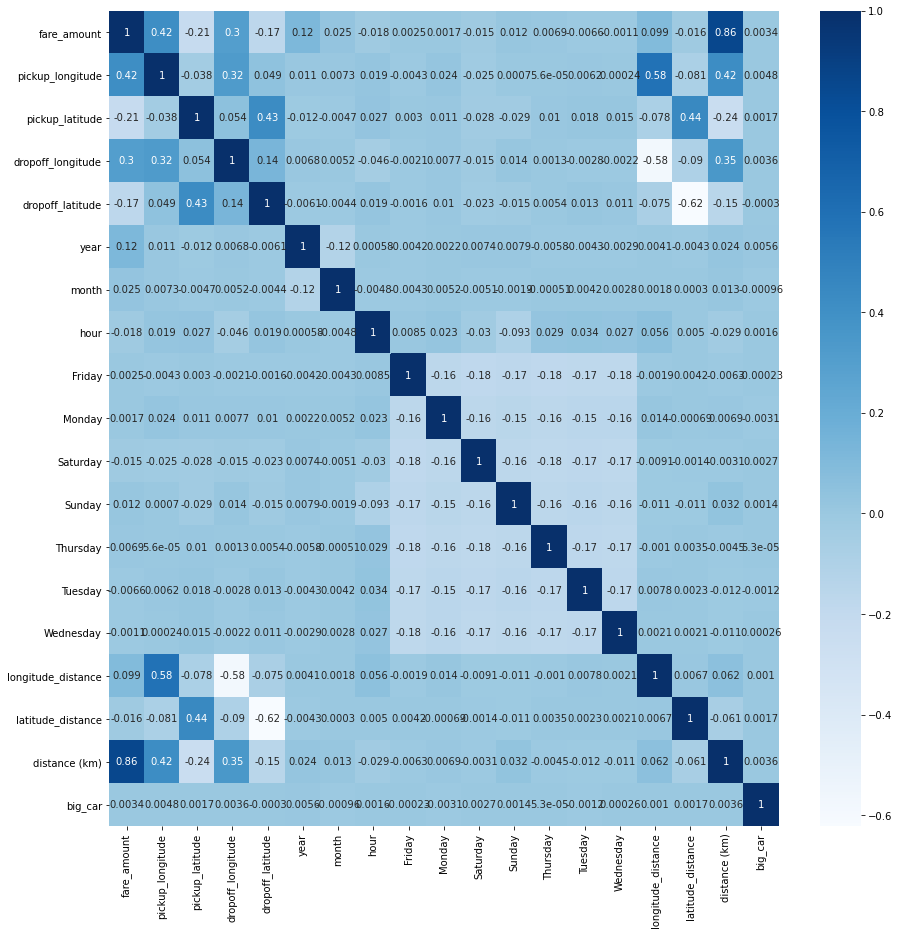

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues');

In [ ]:
y = df[['fare_amount']]
x = df.drop(['fare_amount'], axis=1)

Conver pandas dataframe to pyspark.pandas (train size = 10000, test_size = 2000)

In [ ]:
import pyspark.pandas as ps
train = ps.from_pandas(df[:10000])
test = ps.from_pandas(df[10000:12000])

Conver pyspark.pandas dataframe to spark

In [ ]:
train = train.to_spark()
test = test.to_spark()

# Linear Regression

Create vector column which consists of all features of a datasets except lables

In [ ]:
from pyspark.ml.feature import VectorAssembler
ic = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'year', 'month', 'hour', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'longitude_distance',
       'latitude_distance', 'distance (km)', 'big_car']
numericColumnAssembler = VectorAssembler(inputCols=ic,
                                        outputCol="numericVector")
train_lr = numericColumnAssembler.transform(train)
test_lr = numericColumnAssembler.transform(test)

Train the model

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='numericVector',  labelCol='fare_amount')
lrModel = lr.fit(train_lr)


Results are evaluated using RMSE

In [ ]:
trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.959933
r2: 0.730147


In [ ]:
predictions = lrModel.transform(test_lr)
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="fare_amount",
                                predictionCol="prediction",
                                metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.35749


# Random Forest

Converting train and test dataframes to dataframes with two columns features (all features in a vector) and label

In [ ]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[1:]),r[0]]).toDF(['features', 'label'])

In [ ]:
train_rf = transData(train)
test_rf = transData(test)
train_rf.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-73.844311,40.72...|  4.5|
|[-74.016048,40.71...| 16.9|
+--------------------+-----+
only showing top 2 rows



Create random hyperparameter grid (will be used in RandomizedSearchCV). 
* numbTrees: number of trees in the forest
* featureSubsetStrategy: Number of features to use as candidates for splitting at each tree node
* maxDepth: maximum number of levels in each tree
* minInstancesPerNode: minimum number of data points each child have after a split

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features',labelCol='label')

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt']) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .addGrid(rf.minInstancesPerNode, [2,5,10]) \
    .build()

Create cross-validation with 3 folds, RandomForest estimator, RegressionEvaluator, and ParamGrid

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=RegressionEvaluator(), numFolds=3)

Training and evaluationg results of Random Search (randomly selects sets of parameters from the grid)

In [ ]:
cvModel = crossval.fit(train_rf)
predictions = cvModel.transform(test_rf)

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

The result is much better than linear regression has (4.35749)

In [ ]:
print(rmse)

3.7163677519147646


In [ ]:
bestModel = cvModel.bestModel

The best parameters of RandomForest from Random Search 

In [ ]:
print('numTrees: ', bestModel.getNumTrees)
print('featureSubsetStrategy: ', bestModel.getOrDefault('featureSubsetStrategy'))
print('maxDepth: ', bestModel.getOrDefault('maxDepth'))
print('minInstancesPerNode: ', bestModel.getOrDefault('minInstancesPerNode'))

numTrees:  50
featureSubsetStrategy:  auto
maxDepth:  25
minInstancesPerNode:  5


Comparing the results of two models base model (default parameters) and best model with parameters which were just found above

In [ ]:
base = RandomForestRegressor(featuresCol='features',labelCol='label', seed=42)
base_model = base.fit(train_rf)
train_base = base_model.transform(train_rf)
predictions_base = base_model.transform(test_rf)
rmse_t = evaluator.evaluate(train_base)
rmse = evaluator.evaluate(predictions_base)
print("Base Model")
print("RMSE on train data = %g" % rmse_t)
print("RMSE on test data = %g\n" % rmse)

best = RandomForestRegressor(featuresCol='features',labelCol='label', numTrees=50, maxDepth=25, minInstancesPerNode=5)
best_model = best.fit(train_rf)
train_best = best_model.transform(train_rf)
predictions_best = best_model.transform(test_rf)
rmse_t = evaluator.evaluate(train_best)
rmse = evaluator.evaluate(predictions_best)
print("Best Model")
print("RMSE on train data = %g" % rmse_t)
print("RMSE on test data = %g" % rmse)

Base Model
RMSE on train data = 4.55475
RMSE on test data = 4.34586

Best Model
RMSE on train data = 3.42367
RMSE on test data = 3.75593


There is a significance difference: between base and best model on both training and test sets.

Random search gave some understanding of a range where the perfect parameters can be. It means the we can put much less values for parameters in ParamGrid. Hence, all combinations of parameters can be checked. GridSearch helps us find the best parameters from the new hyperparameter grid. (There is no implementation of GridSearch in spark. So I decided to use sklearn. There is one way how to do this in spark. It is in the last cell of the file. I got an error when tried to use it) 

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RandomForestRegressor_sk
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [25, 29, 33, 37],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [46, 50, 54]
}

rf = RandomForestRegressor_sk()
train_gs = df[['fare_amount']][:10000]
train_gs = df.drop(['fare_amount'], axis=1)[:10000]

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1)
grid_search.fit(train_gs, train_gs)
grid_search.best_params_

{'max_depth': 25, 'min_samples_split': 3, 'n_estimators': 54}

Evaluating the final results and comparing them with the reselts of the model with the parameters from Random Search.

In [ ]:
best = RandomForestRegressor(featuresCol='features',labelCol='label', numTrees=54, maxDepth=25, minInstancesPerNode=5)
best_model = best.fit(train_rf)
train_best = best_model.transform(train_rf)
predictions_best = best_model.transform(test_rf)
rmse_t = evaluator.evaluate(train_best)
rmse = evaluator.evaluate(predictions_best)
print("Best Model")
print("RMSE on train data = %g" % rmse_t)
print("RMSE on test data = %g" % rmse)

Best Model
RMSE on train data = 3.40707
RMSE on test data = 3.71699


Previous results: train (3.42367), test (3.75593)